<a href="https://colab.research.google.com/github/Sa1syo/NLTK/blob/main/IRNLP2019_Ex09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk, re, pprint
from nltk import word_tokenize

# Exercise 9. Extracting Information from Text (Ch. 7)

For International Students: goto http://www.nltk.org/book/ch07.html
Almost corresponded about:

Lesson 1: 7.1 Information Extraction  
Lesson 2: 7.2 Chunking  
Lesson 3: 7.3 Developing and Evaluating Chunkers  
Lesson 4: 7.4 Recursion in Linguistic Structure  
Lesson 5: 7.5 Named Entity Recognition  
Lesson 6: 7.6 Relation Extraction  

(★ Assignment Remark): Please read carefully about 7.2 and 7.3.

Today's Topic:

Extract entities from plain text and extract entity relationships
 - How can I build a system for extracting structured data such as tables from unstructured text?
 - What is a robust way to identify entities and relationships described in the text?
 - Which corpus is suitable for this task? How do you use the corpus to train and evaluate models?

平文からエンティティの抽出と、エンティティの関係性を抽出する
 - 非構造化テキストから表などの構造化データを抽出するシステムをどのように構築できますか。
 - テキストで説明されているエンティティと関係を識別するための堅牢な方法は何ですか？
 - どのコーパスがこの作業に適していますか。また、どのようにコーパスを使用してモデルをトレーニングおよび評価しますか。
 
## 9.1 Information Extraction
データが表形式である場合、これらのクエリに答えるのは簡単です。

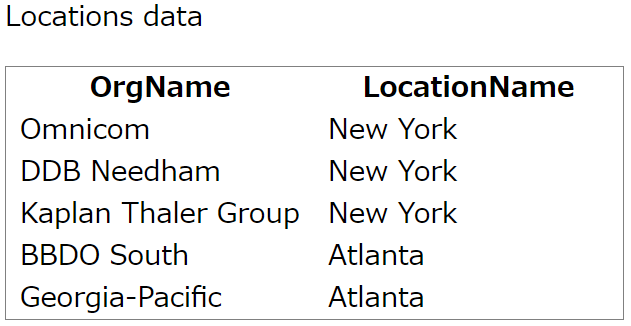

このロケーションデータがタプル（エンティティ、リレーション、エンティティ）のリストとしてPythonに格納されている 場合、「どの組織がアトランタで運営されているのか」という質問になります。次のように翻訳できます。

In [ ]:
locs = [('Omnicom', 'IN', 'New York'),
        ('DDB Needham', 'IN', 'New York'),
        ('Kaplan Thaler Group', 'IN', 'New York'),
        ('BBDO South', 'IN', 'Atlanta'),
        ('Georgia-Pacific', 'IN', 'Atlanta')]
query = [e1 for (e1, rel, e2) in locs if e2=='Atlanta']
print(query)

['BBDO South', 'Georgia-Pacific']


私たちがテキストから同様の情報を得ようとするなら、物事はもっとトリッキーです。  
この章では、異なるアプローチを取り、組織と場所の関係など、テキスト内で非常に具体的な種類の情報のみを探すことにします。  
質問に直接答えるために、まず自然言語文の非構造化データを上記表の構造化データに変換します。  
それから、SQLなどの強力なクエリツールを用いて検索します。  
テキストから意味を得るこの方法は、情報抽出と呼ばれます。

### 9.1.1. 情報抽出アーキテクチャ

下図は単純な情報抽出システムのアーキテクチャを示しています。  
 - 最初に、文書の生テキストはセンテンスセグメンタを使ってセンテンスに分割され、そして各センテンスはさらにトークナイザを使って単語に分割されます。
 - 次に、各文は品詞タグでタグ付けされます。これは、次のステップであるエンティティ検出という名前で非常に役立ちます。このステップでは、各センテンスの中で潜在的に興味深いエンティティの言及を検索します。
 - 最後に、テキスト内の異なるエンティティ間の関連性を検索するために、関連性検出を使用します。

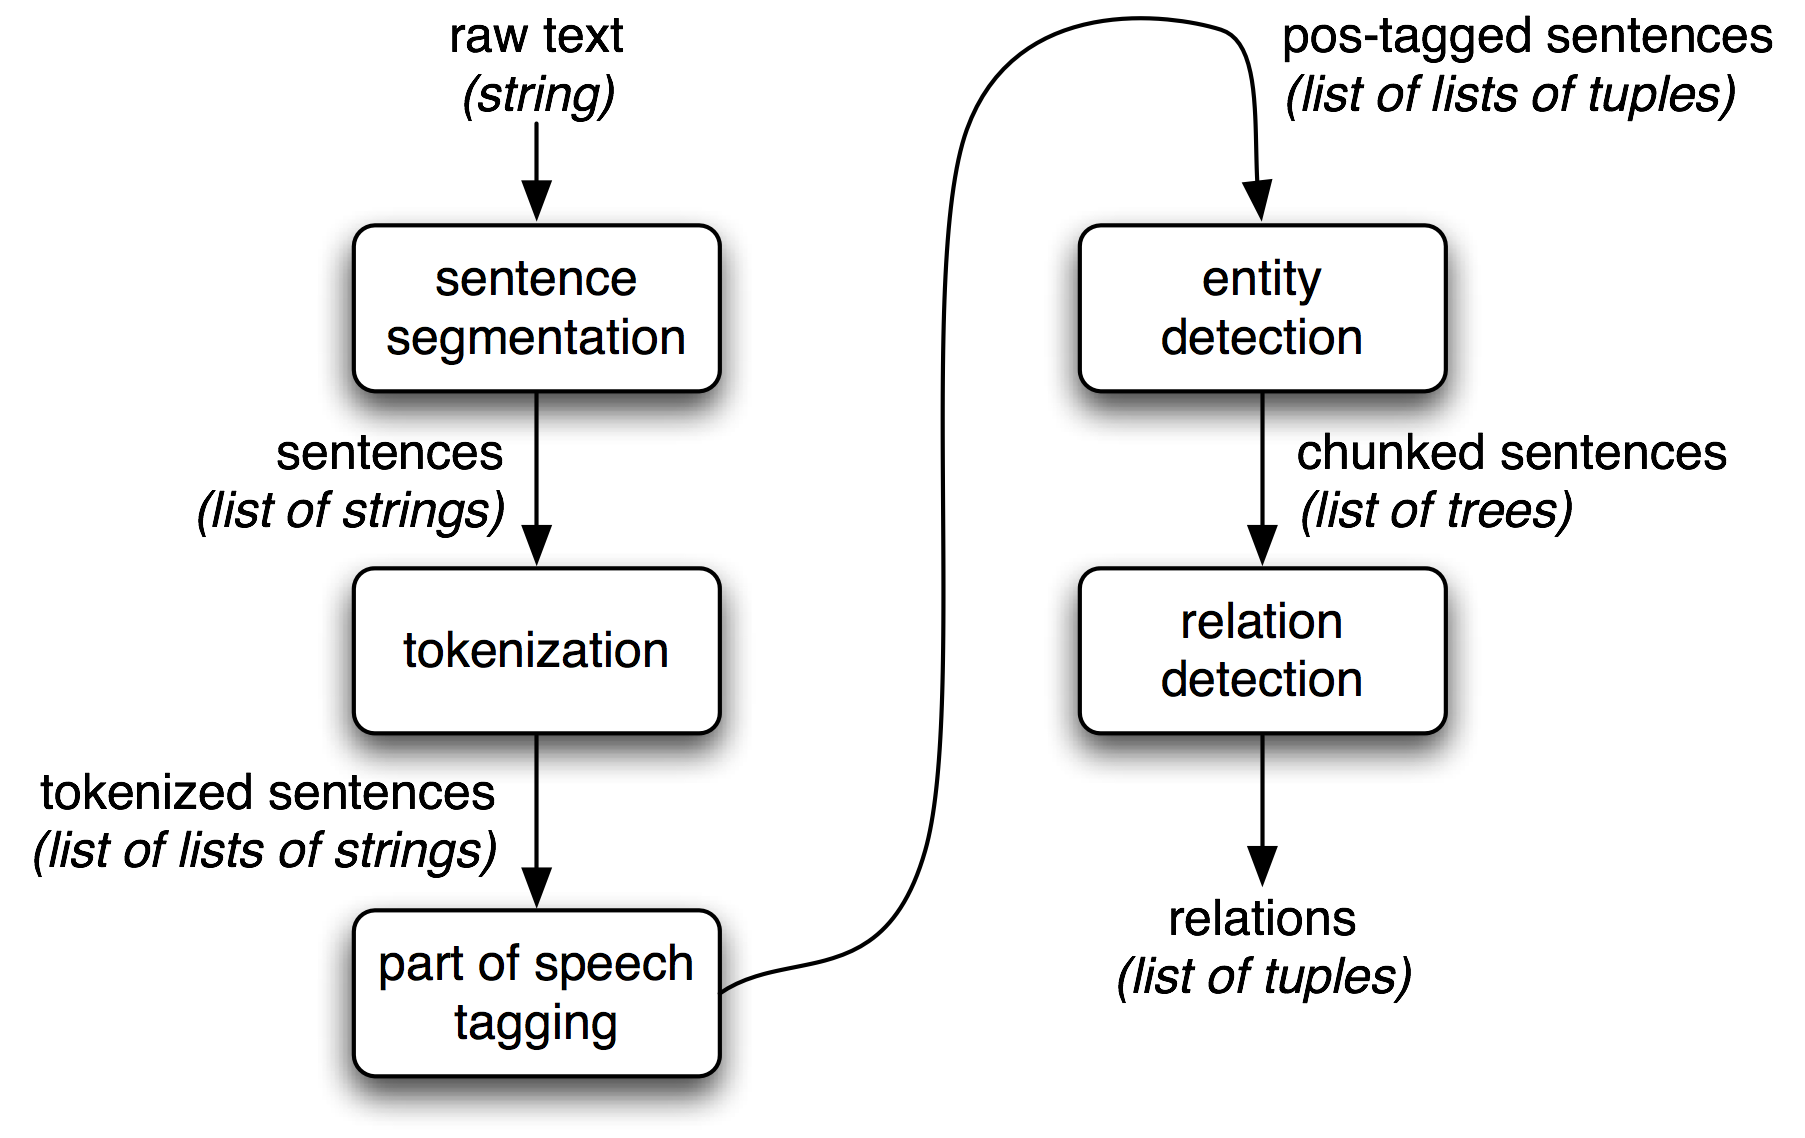

 - 図1.1　情報抽出システムのための単純なパイプラインアーキテクチャ このシステムはドキュメントの生のテキストを入力として受け取り、（エンティティ、リレーション、エンティティ）タプルのリストをその出力として生成します。

最初の3つのタスクを実行するために、NLTKのデフォルトの文章分割機能[1]、単語トークナイザ[2]、および品詞タグ付け 機能を単純に接続する単純な関数を定義できます [3]。

In [ ]:
def ie_preprocess(document):
   sentences = nltk.sent_tokenize(document) #[1]
   sentences = [nltk.word_tokenize(sent) for sent in sentences] #[2]
   sentences = [nltk.pos_tag(sent) for sent in sentences] #[3]

## 9.2. Chunking

エンティティ検出に使用する基本的な手法は チャンキングです。これは、2.1に示すようにマルチトークンシーケンスをセグメント化してラベルを付けることです。

 - 小さい方のボックスは単語レベルのトークン化と品詞のタグ付けを示し、大きい方のボックスは高レベルのチャンキングを示しています。
 - これらの大きな箱はそれぞれチャンクと呼ばれます。

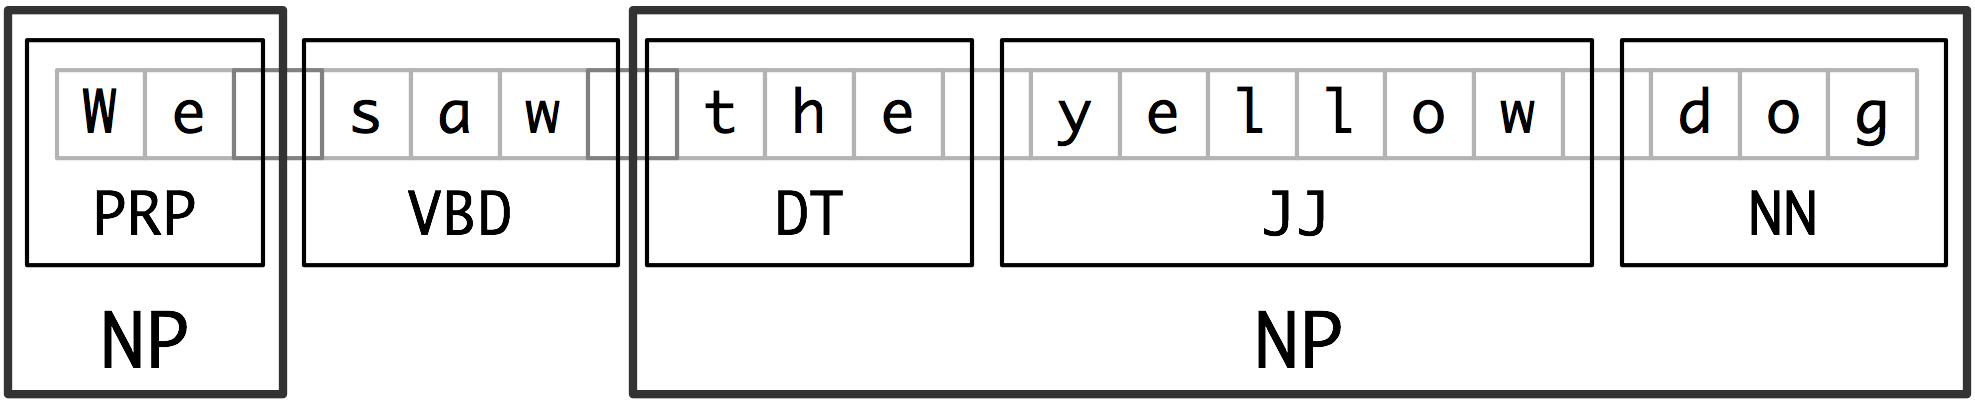

- 図2.1：トークンレベルとチャンクレベルの両方でのセグメンテーションとラベリング

このセクションでは、チャンクの定義と表現から始めて、チャンクをある程度詳しく探ります。

チャンキングに対する正規表現とn-gramのアプローチを見て、CoNLL-2000チャンキングコーパスを使用してチャンクを開発し、評価します。

その後、名前付き実体認識と関係抽出のタスクに戻ります。

### 9.2.1. Noun Phrase Chunking
(★ Assingment Remark)  
個々の名詞句に対応するチャンクを検索する、名詞句チャンキング、またはNP- チャンキングのタスクを検討することから始めます。


- NPチャンキングのための最も有用な情報源の1つは品詞タグです。
- これは、私たちの情報抽出システムで品詞タグ付けを実行する動機の1つです。
- 2.2で品詞タグ付けされた例文を使ってこのアプローチを説明します。
- NPチャンクを作成するために、 文をチャンクする方法を示す規則からなるチャンク文法を最初に定義します。
 - この場合は、単一の正規表現規則を使用して単純な文法を定義します [2]。
 - この規則は、チャンクが任意の数の形容詞（JJ）が続くオプションの決定子（DT）を見つけると必ずNPチャンクが形成されるべきであると言います。そして名詞（NN）。
 - この文法を使用して、チャンクパーサーを作成し、[3]例文でそれをテストします[4]。
 - 結果は木になり、それを印刷することも[5]、グラフィカルに表示することもできます[6]。

In [ ]:
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"), 
("dog", "NN"), ("barked", "VBD"), ("at", "IN"),  ("the", "DT"), ("cat", "NN")] #[1]
grammar = "NP: {<DT>?<JJ>*<NN>}" #[2]

cp = nltk.RegexpParser(grammar) #[3]
result = cp.parse(sentence) #[4]
print(result) #[5]

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


<pre> result.draw() #[6] </pre>
This line is not move on Google Colab.

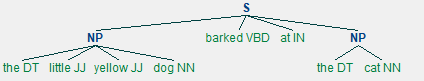

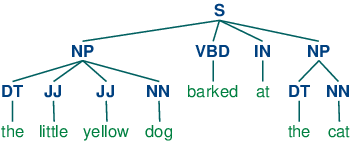

### 9.2.2. Tag Patterns
(★ Assignment Remark)
チャンク文法を構成する規則は、タグ付けされた単語のシーケンスを記述するためにタグパターンを使用します。

- タグパターンは、山括弧を使用して区切られた品詞タグのシーケンスです（例：&lt;DT&gt;？&lt;JJ&gt; * &lt;NN&gt;）。

- タグパターンは正規表現パターン（3.4）に似ています。

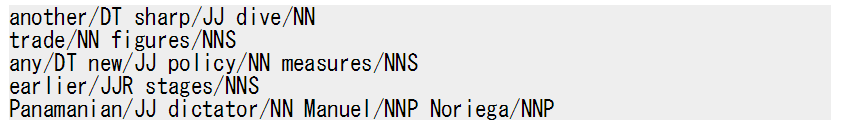


### 9.2.3   Chunking with Regular Expressions
- 与えられた文のチャンク構造を見つけるために、RegexpParser チャンクは、トークンがチャンクされていないフラットな構造から始まります。
- チャンクルールが順番に適用され、チャンク構造が順次更新されます。すべてのルールが呼び出されると、結果のチャンク構造が返されます。

下の例は2つの規則からなる簡単なチャンク文法を示しています。
- 最初の規則は、オプションの決定詞または所有代名詞、0個以上の形容詞、次に名詞に一致します。2番目の規則は、1つ以上の固有名詞に一致します。
- また、チャンクする例文を定義し、[1]この入力に対してチャンクを実行します[2]。

In [ ]:
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
      {<NNP>+}                # chunk sequences of proper nouns
"""
cp = nltk.RegexpParser(grammar)
sentence = [("Rapunzel", "NNP"), ("let", "VBD"), ("down", "RP"), #[1]
                 ("her", "PP$"), ("long", "JJ"), ("golden", "JJ"), ("hair", "NN")]


In [ ]:
print(cp.parse(sentence))

(S
  (NP Rapunzel/NNP)
  let/VBD
  down/RP
  (NP her/PP$ long/JJ golden/JJ hair/NN))


タグパターンが重複する位置で一致した場合は、一番左の一致が優先されます。たとえば、2つの連続名詞を3つの連続名詞を含むテキストに一致させるルールを適用すると、最初の2つの名詞だけがチャンクされます。

In [ ]:
nouns = [("money", "NN"), ("market", "NN"), ("fund", "NN")]
grammar = "NP: {<NN><NN>}  # Chunk two consecutive nouns"
cp = nltk.RegexpParser(grammar)
print(cp.parse(nouns))

(S (NP money/NN market/NN) fund/NN)


ひとたびmoney marketのチャンクを作成したら、fundをチャンクに含めることを許可するという文脈を削除しました。この問題は、NP：{&lt;NN&gt; +}のように、より寛容なチャンクルールを使用することで回避できました。

### 9.2.4. Exploring Text Corpora
NLTK 5.2.でタグ付きコーパスを調べて、品詞タグの特定のシーケンスに一致するフレーズを抽出する方法を説明しました。次のように、チャンクを使って同じ作業をより簡単に行うことができます。

In [ ]:
nltk.download('brown')
cp = nltk.RegexpParser('CHUNK: {<V.*> <TO> <V.*>}')
brown = nltk.corpus.brown
for sent in brown.tagged_sents():
    tree = cp.parse(sent)
    for subtree in tree.subtrees():
        if subtree.label() == 'CHUNK': print(subtree)

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\yagu1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


(CHUNK combined/VBN to/TO achieve/VB)
(CHUNK continue/VB to/TO place/VB)
(CHUNK serve/VB to/TO protect/VB)
(CHUNK wanted/VBD to/TO wait/VB)
(CHUNK allowed/VBN to/TO place/VB)
(CHUNK expected/VBN to/TO become/VB)
(CHUNK expected/VBN to/TO approve/VB)
(CHUNK expected/VBN to/TO make/VB)
(CHUNK intends/VBZ to/TO make/VB)
(CHUNK seek/VB to/TO set/VB)
(CHUNK like/VB to/TO see/VB)
(CHUNK designed/VBN to/TO provide/VB)
(CHUNK get/VB to/TO hear/VB)
(CHUNK expects/VBZ to/TO tell/VB)
(CHUNK expected/VBN to/TO give/VB)
(CHUNK prefer/VB to/TO pay/VB)
(CHUNK required/VBN to/TO obtain/VB)
(CHUNK permitted/VBN to/TO teach/VB)
(CHUNK designed/VBN to/TO reduce/VB)
(CHUNK Asked/VBN to/TO elaborate/VB)
(CHUNK got/VBN to/TO go/VB)
(CHUNK raised/VBN to/TO pay/VB)
(CHUNK scheduled/VBN to/TO go/VB)
(CHUNK cut/VBN to/TO meet/VB)
(CHUNK needed/VBN to/TO meet/VB)
(CHUNK hastened/VBD to/TO add/VB)
(CHUNK found/VBN to/TO prevent/VB)
(CHUNK continue/VB to/TO insist/VB)
(CHUNK compelled/VBN to/TO make/VB)
(CHUNK mad

(CHUNK prepared/VBN to/TO discuss/VB)
(CHUNK wanted/VBD to/TO go/VB)
(CHUNK allowed/VBN to/TO file/VB)
(CHUNK tried/VBD to/TO persuade/VB)
(CHUNK began/VBD to/TO tell/VB)
(CHUNK hoped/VBD to/TO peddle/VB)
(CHUNK intended/VBN to/TO insure/VB)
(CHUNK decided/VBD to/TO provide/VB)
(CHUNK expected/VBN to/TO go/VB)
(CHUNK expected/VBN to/TO sign/VB)
(CHUNK like/VB to/TO eat/VB)
(CHUNK like/VB to/TO talk/VB)
(CHUNK ceased/VBN to/TO grumble/VB)
(CHUNK tending/VBG to/TO bid/VB)
(CHUNK start/VB to/TO pay/VB)
(CHUNK failed/VBN to/TO measure/VB)
(CHUNK going/VBG to/TO take/VB)
(CHUNK needed/VBN to/TO push/VB)
(CHUNK trying/VBG to/TO get/VB)
(CHUNK try/VB to/TO get/VB)
(CHUNK want/VB to/TO increase/VB)
(CHUNK wants/VBZ to/TO bring/VB)
(CHUNK threaten/VB to/TO strike/VB)
(CHUNK begun/VBN to/TO grow/VB)
(CHUNK combine/VB to/TO serve/VB)
(CHUNK helping/VBG to/TO strengthen/VB)
(CHUNK designed/VBN to/TO promote/VB)
(CHUNK threatening/VBG to/TO expand/VB)
(CHUNK seeks/VBZ to/TO get/VB)
(CHUNK begin/VB 

(CHUNK forced/VBN to/TO rely/VB)
(CHUNK attempt/VB to/TO homogenize/VB)
(CHUNK like/VB to/TO put/VB)
(CHUNK continue/VB to/TO try/VB)
(CHUNK seem/VB to/TO deal/VB)
(CHUNK decide/VB to/TO let/VB)
(CHUNK tries/VBZ to/TO take/VB)
(CHUNK trying/VBG to/TO forget/VB)
(CHUNK trying/VBG to/TO acquire/VB)
(CHUNK threatens/VBZ to/TO linger/VB)
(CHUNK decided/VBN to/TO forego/VB)
(CHUNK managed/VBN to/TO hold/VB)
(CHUNK intended/VBN to/TO illustrate/VB)
(CHUNK tried/VBN to/TO get/VB)
(CHUNK learn/VB to/TO live/VB)
(CHUNK helping/VBG to/TO move/VB)
(CHUNK striving/VBG to/TO hold/VB)
(CHUNK choose/VB to/TO work/VB)
(CHUNK tried/VBD to/TO see/VB)
(CHUNK trying/VBG to/TO create/VB)
(CHUNK made/VBN to/TO appear/VB)
(CHUNK failed/VBD to/TO make/VB)
(CHUNK seemed/VBD to/TO deserve/VB)
(CHUNK managed/VBN to/TO mix/VB)
(CHUNK want/VB to/TO hurt/VB)
(CHUNK liked/VBD to/TO nip/VB)
(CHUNK manages/VBZ to/TO acquire/VB)
(CHUNK widened/VBN to/TO enchant/VB)
(CHUNK serve/VB to/TO contradict/VB)
(CHUNK dare/VB to

(CHUNK began/VBD to/TO motor/VB)
(CHUNK trained/VBN to/TO drag/VB)
(CHUNK fled/VBD to/TO make/VB)
(CHUNK seemed/VBD to/TO know/VB)
(CHUNK used/VBD to/TO say/VB)
(CHUNK preferred/VBD to/TO get/VB)
(CHUNK hope/VB to/TO cover/VB)
(CHUNK want/VB to/TO miss/VB)
(CHUNK scheduled/VBN to/TO vanish/VB)
(CHUNK continued/VBD to/TO live/VB)
(CHUNK seem/VB to/TO cascade/VB)
(CHUNK forget/VB to/TO buy/VB)
(CHUNK fail/VB to/TO shorten/VB)
(CHUNK intend/VB to/TO cook/VB)
(CHUNK sized/VBN to/TO fit/VB)
(CHUNK continue/VB to/TO release/VB)
(CHUNK wish/VB to/TO create/VB)
(CHUNK trim/VB to/TO fit/VB)
(CHUNK cut/VBN to/TO fit/VB)
(CHUNK help/VB to/TO prevent/VB)
(CHUNK designed/VBN to/TO take/VB)
(CHUNK used/VBN to/TO transport/VB)
(CHUNK want/VB to/TO buy/VB)
(CHUNK used/VBN to/TO fasten/VB)
(CHUNK help/VB to/TO keep/VB)
(CHUNK needed/VBN to/TO build/VB)
(CHUNK designed/VBN to/TO accommodate/VB)
(CHUNK adjusted/VBN to/TO suit/VB)
(CHUNK used/VBN to/TO cut/VB)
(CHUNK want/VB to/TO avoid/VB)
(CHUNK agreed/

(CHUNK wanted/VBD to/TO clarify/VB)
(CHUNK proposed/VBD to/TO sail/VB)
(CHUNK determined/VBN to/TO catch/VB)
(CHUNK forced/VBN to/TO turn/VB)
(CHUNK seemed/VBD to/TO sense/VB)
(CHUNK seemed/VBD to/TO know/VB)
(CHUNK tried/VBD to/TO brush/VB)
(CHUNK turning/VBG to/TO repeat/VB)
(CHUNK tried/VBN to/TO persuade/VB)
(CHUNK wanted/VBN to/TO turn/VB)
(CHUNK preparing/VBG to/TO pacify/VB)
(CHUNK forced/VBN to/TO retreat/VB)
(CHUNK contracted/VBD to/TO supply/VB)
(CHUNK forced/VBN to/TO leave/VB)
(CHUNK offering/VBG to/TO bring/VB)
(CHUNK attempt/VB to/TO bring/VB)
(CHUNK decided/VBD to/TO cast/VB)
(CHUNK liked/VBD to/TO tease/VB)
(CHUNK going/VBG to/TO buy/VB)
(CHUNK com/VB to/TO sea/VB)
(CHUNK drilled/VBN to/TO follow/VB)
(CHUNK born/VBN to/TO command/VB)
(CHUNK come/VBN to/TO recognize/VB)
(CHUNK allowed/VBN to/TO account/VB)
(CHUNK created/VBN to/TO fan/VB)
(CHUNK come/VBN to/TO mean/VB)
(CHUNK trying/VBG to/TO make/VB)
(CHUNK refusing/VBG to/TO keep/VB)
(CHUNK wishes/VBZ to/TO discuss/VB)

(CHUNK continue/VB to/TO view/VB)
(CHUNK try/VB to/TO coerce/VB)
(CHUNK likes/VBZ to/TO believe/VB)
(CHUNK continue/VB to/TO affect/VB)
(CHUNK served/VBD to/TO overcome/VB)
(CHUNK tends/VBZ to/TO further/VB)
(CHUNK help/VB to/TO reveal/VB)
(CHUNK struggle/VB to/TO assert/VB)
(CHUNK said/VBN to/TO exist/VB)
(CHUNK taken/VBN to/TO guard/VB)
(CHUNK done/VBN to/TO increase/VB)
(CHUNK ready/VB to/TO tick/VB)
(CHUNK forced/VBN to/TO hypothesize/VB)
(CHUNK used/VBN to/TO challenge/VB)
(CHUNK permitted/VBN to/TO authorize/VB)
(CHUNK decides/VBZ to/TO break/VB)
(CHUNK required/VBN to/TO pass/VB)
(CHUNK decide/VB to/TO clobber/VB)
(CHUNK decided/VBD to/TO reverse/VB)
(CHUNK tried/VBD to/TO start/VB)
(CHUNK forbidden/VBN to/TO fly/VB)
(CHUNK required/VBN to/TO copy/VB)
(CHUNK began/VBD to/TO move/VB)
(CHUNK run/VB to/TO live/VB)
(CHUNK started/VBD to/TO glance/VB)
(CHUNK try/VB to/TO memorize/VB)
(CHUNK turned/VBD to/TO look/VB)
(CHUNK trying/VBG to/TO talk/VB)
(CHUNK started/VBD to/TO decline/VB

(CHUNK instructed/VBN to/TO burn/VB)
(CHUNK attempted/VBD to/TO conclude/VB)
(CHUNK equipped/VBN to/TO handle/VB)
(CHUNK trying/VBG to/TO check/VB)
(CHUNK mean/VB to/TO write/VB)
(CHUNK wished/VBD to/TO pursue/VB)
(CHUNK refused/VBD to/TO attend/VB)
(CHUNK decided/VBD to/TO dance/VB)
(CHUNK failed/VBN to/TO amaze/VB)
(CHUNK continued/VBD to/TO search/VB)
(CHUNK threatening/VBG to/TO swallow/VB)
(CHUNK pleased/VBN to/TO see/VB)
(CHUNK tried/VBD to/TO discover/VB)
(CHUNK disturbed/VBN to/TO find/VB)
(CHUNK failed/VBN to/TO realize/VB)
(CHUNK manage/VB to/TO get/VB)
(CHUNK wanted/VBD to/TO buy/VB)
(CHUNK decided/VBD to/TO bypass/VB)
(CHUNK allowed/VBN to/TO preach/VB)
(CHUNK allowed/VBN to/TO pass/VB)
(CHUNK dared/VBN to/TO drop/VB)
(CHUNK expected/VBN to/TO move/VB)
(CHUNK means/VBZ to/TO ridicule/VB)
(CHUNK hesitate/VB to/TO sacrifice/VB)
(CHUNK forced/VBN to/TO move/VB)
(CHUNK taken/VBN to/TO effect/VB)
(CHUNK hoped/VBD to/TO imprint/VB)
(CHUNK tailored/VBN to/TO fit/VB)
(CHUNK obliged

(CHUNK wishes/VBZ to/TO express/VB)
(CHUNK continue/VB to/TO bridge/VB)
(CHUNK struggle/VB to/TO keep/VB)
(CHUNK begin/VB to/TO look/VB)
(CHUNK began/VBD to/TO feel/VB)
(CHUNK begins/VBZ to/TO doubt/VB)
(CHUNK seemed/VBD to/TO survive/VB)
(CHUNK begins/VBZ to/TO dream/VB)
(CHUNK refuses/VBZ to/TO surrender/VB)
(CHUNK began/VBD to/TO discover/VB)
(CHUNK decided/VBN to/TO seek/VB)
(CHUNK seek/VB to/TO eliminate/VB)
(CHUNK organized/VBN to/TO deal/VB)
(CHUNK expected/VBN to/TO consist/VB)
(CHUNK beginning/VBG to/TO use/VB)
(CHUNK tried/VBN to/TO enter/VB)
(CHUNK forced/VBN to/TO play/VB)
(CHUNK want/VB to/TO quibble/VB)
(CHUNK used/VBD to/TO make/VB)
(CHUNK love/VB to/TO suffer/VB)
(CHUNK love/VB to/TO suffer/VB)
(CHUNK came/VBD to/TO believe/VB)
(CHUNK trying/VBG to/TO outdo/VB)
(CHUNK used/VBD to/TO say/VB)
(CHUNK castigates/VBZ to/TO liberate/VB)
(CHUNK helped/VBD to/TO educate/VB)
(CHUNK expect/VB to/TO find/VB)
(CHUNK supposed/VBN to/TO supplant/VB)
(CHUNK wanted/VBD to/TO write/VB)


(CHUNK assumed/VBN to/TO originate/VB)
(CHUNK used/VBN to/TO describe/VB)
(CHUNK expected/VBN to/TO cause/VB)
(CHUNK taken/VBN to/TO study/VB)
(CHUNK required/VBN to/TO ensure/VB)
(CHUNK used/VBN to/TO measure/VB)
(CHUNK used/VBN to/TO start/VB)
(CHUNK started/VBD to/TO strike/VB)
(CHUNK allowed/VBN to/TO pull/VB)
(CHUNK used/VBN to/TO measure/VB)
(CHUNK generalized/VBN to/TO include/VB)
(CHUNK eliminated/VBN to/TO obtain/VB)
(CHUNK extended/VBN to/TO include/VB)
(CHUNK used/VBN to/TO derive/VB)
(CHUNK adjusted/VBN to/TO minimize/VB)
(CHUNK required/VBN to/TO make/VB)
(CHUNK taken/VBN to/TO prevent/VB)
(CHUNK attempts/VBZ to/TO present/VB)
(CHUNK evaporate/VB to/TO leave/VB)
(CHUNK tend/VB to/TO stick/VB)
(CHUNK helps/VBZ to/TO float/VB)
(CHUNK acts/VBZ to/TO remove/VB)
(CHUNK tend/VB to/TO accelerate/VB)
(CHUNK appear/VB to/TO offer/VB)
(CHUNK allowed/VBN to/TO take/VB)
(CHUNK allowed/VBN to/TO distil/VB)
(CHUNK undertaken/VBN to/TO see/VB)
(CHUNK allowed/VBN to/TO stand/VB)
(CHUNK th

(CHUNK used/VBN to/TO pay/VB)
(CHUNK taken/VBN to/TO indicate/VB)
(CHUNK afford/VB to/TO trade/VB)
(CHUNK afford/VB to/TO lose/VB)
(CHUNK taken/VBN to/TO exemplify/VB)
(CHUNK Try/VB to/TO imagine/VB)
(CHUNK trying/VBG to/TO outfox/VB)
(CHUNK trying/VBG to/TO get/VB)
(CHUNK invited/VBN to/TO try/VB)
(CHUNK begin/VB to/TO affect/VB)
(CHUNK tend/VB to/TO move/VB)
(CHUNK required/VBN to/TO pay/VB)
(CHUNK seek/VB to/TO force/VB)
(CHUNK act/VB to/TO accentuate/VB)
(CHUNK begin/VB to/TO edge/VB)
(CHUNK move/VB to/TO restrain/VB)
(CHUNK continue/VB to/TO press/VB)
(CHUNK trying/VBG to/TO win/VB)
(CHUNK bound/VBN to/TO mean/VB)
(CHUNK continue/VB to/TO move/VB)
(CHUNK continue/VB to/TO rise/VB)
(CHUNK operate/VB to/TO keep/VB)
(CHUNK expected/VBN to/TO put/VB)
(CHUNK presumed/VBN to/TO realize/VB)
(CHUNK assembled/VBD to/TO legislate/VB)
(CHUNK sought/VBD to/TO find/VB)
(CHUNK tend/VB to/TO view/VB)
(CHUNK wished/VBD to/TO minimize/VB)
(CHUNK designed/VBN to/TO deal/VB)
(CHUNK ordered/VBN to/TO

(CHUNK helping/VBG to/TO define/VB)
(CHUNK trying/VBG to/TO avoid/VB)
(CHUNK trying/VBG to/TO get/VB)
(CHUNK made/VBN to/TO symbolize/VB)
(CHUNK kneels/VBZ to/TO kiss/VB)
(CHUNK serve/VB to/TO travesty/VB)
(CHUNK used/VBN to/TO equate/VB)
(CHUNK altered/VBN to/TO show/VB)
(CHUNK altered/VBN to/TO show/VB)
(CHUNK taken/VBN to/TO branch/VB)
(CHUNK attempt/VB to/TO execute/VB)
(CHUNK used/VBN to/TO name/VB)
(CHUNK used/VBN to/TO name/VB)
(CHUNK used/VBN to/TO generate/VB)
(CHUNK used/VBN to/TO select/VB)
(CHUNK used/VBN to/TO select/VB)
(CHUNK used/VBN to/TO specify/VB)
(CHUNK used/VBN to/TO specify/VB)
(CHUNK expected/VBN to/TO serve/VB)
(CHUNK used/VBN to/TO eliminate/VB)
(CHUNK designed/VBN to/TO handle/VB)
(CHUNK made/VBN to/TO take/VB)
(CHUNK tended/VBD to/TO float/VB)
(CHUNK began/VBD to/TO decrease/VB)
(CHUNK began/VBD to/TO build/VB)
(CHUNK used/VBN to/TO provide/VB)
(CHUNK tend/VB to/TO ensure/VB)
(CHUNK seems/VBZ to/TO strive/VB)
(CHUNK stated/VBN to/TO emphasize/VB)
(CHUNK chan

(CHUNK want/VB to/TO see/VB)
(CHUNK beginning/VBG to/TO see/VB)
(CHUNK bother/VB to/TO wipe/VB)
(CHUNK fit/VBN to/TO shake/VB)
(CHUNK going/VBG to/TO wake/VB)
(CHUNK care/VB to/TO get/VB)
(CHUNK tried/VBN to/TO stop/VB)
(CHUNK expected/VBD to/TO hear/VB)
(CHUNK got/VBD to/TO expect/VB)
(CHUNK going/VBG to/TO put/VB)
(CHUNK got/VBN to/TO thaw/VB)
(CHUNK want/VB to/TO touch/VB)
(CHUNK made/VBN to/TO fall/VB)
(CHUNK come/VB to/TO rest/VB)
(CHUNK trying/VBG to/TO attain/VB)
(CHUNK stopped/VBD to/TO gaze/VB)
(CHUNK begun/VBN to/TO turn/VB)
(CHUNK beginning/VBG to/TO cook/VB)
(CHUNK began/VBD to/TO develop/VB)
(CHUNK begun/VBN to/TO buy/VB)
(CHUNK want/VB to/TO thin/VB)
(CHUNK planned/VBD to/TO graduate/VB)
(CHUNK going/VBG to/TO tell/VB)
(CHUNK trying/VBG to/TO get/VB)
(CHUNK want/VB to/TO roast/VB)
(CHUNK preferred/VBD to/TO sit/VB)
(CHUNK liked/VBD to/TO sit/VB)
(CHUNK seemed/VBN to/TO come/VB)
(CHUNK plan/VB to/TO conduct/VB)
(CHUNK required/VBN to/TO detect/VB)
(CHUNK obliged/VBN to/TO 

(CHUNK began/VBD to/TO thrash/VB)
(CHUNK get/VB to/TO work/VB)
(CHUNK come/VBN to/TO work/VB)
(CHUNK want/VB to/TO see/VB)
(CHUNK wanted/VBD to/TO get/VB)
(CHUNK want/VB to/TO go/VB)
(CHUNK managed/VBD to/TO swallow/VB)
(CHUNK threatened/VBD to/TO fire/VB)
(CHUNK happen/VB to/TO see/VB)
(CHUNK going/VBG to/TO eat/VB)
(CHUNK began/VBD to/TO weep/VB)
(CHUNK happens/VBZ to/TO ask/VB)
(CHUNK want/VB to/TO rent/VB)
(CHUNK Try/VB to/TO imagine/VB)
(CHUNK promised/VBN to/TO pay/VB)
(CHUNK planning/VBG to/TO remarry/VB)
(CHUNK determined/VBN to/TO get/VB)
(CHUNK seemed/VBD to/TO swell/VB)
(CHUNK surprised/VBN to/TO meet/VB)
(CHUNK trying/VBG to/TO tell/VB)
(CHUNK known/VBN to/TO run/VB)
(CHUNK seem/VB to/TO preserve/VB)
(CHUNK got/VBD to/TO understand/VB)
(CHUNK got/VBN to/TO know/VB)
(CHUNK came/VBD to/TO ask/VB)
(CHUNK asked/VBD to/TO see/VB)
(CHUNK began/VBD to/TO abuse/VB)
(CHUNK hurry/VB to/TO hang/VB)
(CHUNK seemed/VBD to/TO mind/VB)
(CHUNK started/VBD to/TO cross/VB)
(CHUNK started/VBD 

(CHUNK rejoicing/VBG to/TO think/VB)
(CHUNK like/VB to/TO get/VB)
(CHUNK tried/VBD to/TO go/VB)
(CHUNK seemed/VBD to/TO make/VB)
(CHUNK aim/VB to/TO give/VB)
(CHUNK want/VB to/TO trade/VB)
(CHUNK beginning/VBG to/TO turn/VB)
(CHUNK forced/VBN to/TO maintain/VB)
(CHUNK hope/VB to/TO locate/VB)
(CHUNK paused/VBD to/TO gather/VB)
(CHUNK bothering/VBG to/TO note/VB)
(CHUNK turned/VBD to/TO survey/VB)
(CHUNK started/VBD to/TO struggle/VB)
(CHUNK started/VBD to/TO return/VB)
(CHUNK pretended/VBN to/TO give/VB)
(CHUNK served/VBD to/TO increase/VB)
(CHUNK determined/VBN to/TO drive/VB)
(CHUNK try/VB to/TO go/VB)
(CHUNK began/VBD to/TO run/VB)
(CHUNK continued/VBD to/TO come/VB)
(CHUNK continued/VBN to/TO camouflage/VB)
(CHUNK Forced/VBN to/TO realize/VB)
(CHUNK trying/VBG to/TO grab/VB)
(CHUNK trying/VBG to/TO read/VB)
(CHUNK began/VBD to/TO drink/VB)
(CHUNK started/VBD to/TO slide/VB)
(CHUNK mean/VB to/TO pry/VB)
(CHUNK going/VBG to/TO sell/VB)
(CHUNK pleased/VBN to/TO hear/VB)
(CHUNK startin

(CHUNK got/VBN to/TO admit/VB)
(CHUNK tried/VBD to/TO leave/VB)
(CHUNK began/VBD to/TO walk/VB)
(CHUNK supposed/VBD to/TO stay/VB)
(CHUNK going/VBG to/TO tell/VB)
(CHUNK going/VBG to/TO get/VB)
(CHUNK intended/VBN to/TO make/VB)
(CHUNK began/VBD to/TO zip/VB)
(CHUNK obliged/VBN to/TO roll/VB)
(CHUNK want/VB to/TO stop/VB)
(CHUNK going/VBG to/TO marry/VB)
(CHUNK liked/VBD to/TO hear/VB)
(CHUNK tempted/VBN to/TO tell/VB)
(CHUNK seemed/VBD to/TO mark/VB)
(CHUNK tried/VBD to/TO explain/VB)
(CHUNK managed/VBD to/TO look/VB)
(CHUNK needed/VBD to/TO get/VB)
(CHUNK answered/VBD to/TO find/VB)
(CHUNK afford/VB to/TO get/VB)
(CHUNK started/VBD to/TO look/VB)
(CHUNK takes/VBZ to/TO get/VB)
(CHUNK going/VBG to/TO get/VB)
(CHUNK tried/VBD to/TO quiet/VB)
(CHUNK trying/VBG to/TO sound/VB)
(CHUNK came/VBD to/TO meet/VB)
(CHUNK seemed/VBD to/TO focus/VB)
(CHUNK want/VB to/TO talk/VB)
(CHUNK want/VB to/TO see/VB)
(CHUNK wants/VBZ to/TO get/VB)
(CHUNK went/VBD to/TO turn/VB)
(CHUNK surprised/VBN to/TO f

### 9.2.5. Chinking

チャンクから除外したいものを定義する方が簡単なことがあります。

chink(裂け目) チャンクに含まれていないトークンのシーケンス。

次の例では、barked/VBD at/IN がchinkです。

    [ the/DT little/JJ yellow/JJ dog/NN ] barked/VBD at/IN [ the/DT cat/NN ]

Chinkは、チャンクから一連のトークンを削除するプロセスです。
 - 一致するトークンのシーケンスがチャンク全体に及ぶ場合は、チャンク全体が削除されます。
 - 一連のトークンがチャンクの中央に表示される場合、これらのトークンは削除され、前に1つしかなかった場所に2つのチャンクが残ります。
 - シーケンスがチャンクの周辺にある場合、これらのトークンは削除され、小さなチャンクが残ります。
![image.png](attachment:image.png)

In [ ]:
grammar = r"""
  NP:
    {<.*>+}          # Chunk everything
    }<VBD|IN>+{      # Chink sequences of VBD and IN
  """
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),
       ("dog", "NN"), ("barked", "VBD"), ("at", "IN"),  ("the", "DT"), ("cat", "NN")]
cp = nltk.RegexpParser(grammar)

In [ ]:
print(cp.parse(sentence))

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


### 9.2.6. Representing Chunks: Tags vs Trees

タグ付けと構文解析（8）の中間的な状況に適しているため、チャンク構造はタグまたはツリーを使用して表すことができます。

最も普及しているファイル表現はIOBタグを使用しています。

この方式では、各トークンは、3つの特別なチャンクタグ、I（inside）、O（outside）、またはB（begin）のいずれかでタグ付けされています。

 - トークンがチャンクの始まりを示す場合、トークンはBとしてタグ付けされます。
 - チャンク内の後続のトークンはIとタグ付けされます。他のすべてのトークンはOとタグ付けされています。
 - BとIタグは、チャンクタイプ、例えば接尾辞されているB-NP、I-NP。
 - もちろん、チャンクの外側に現れるトークンに対してチャンクタイプを指定する必要はないので、これらは単にOとラベル付けされています。

 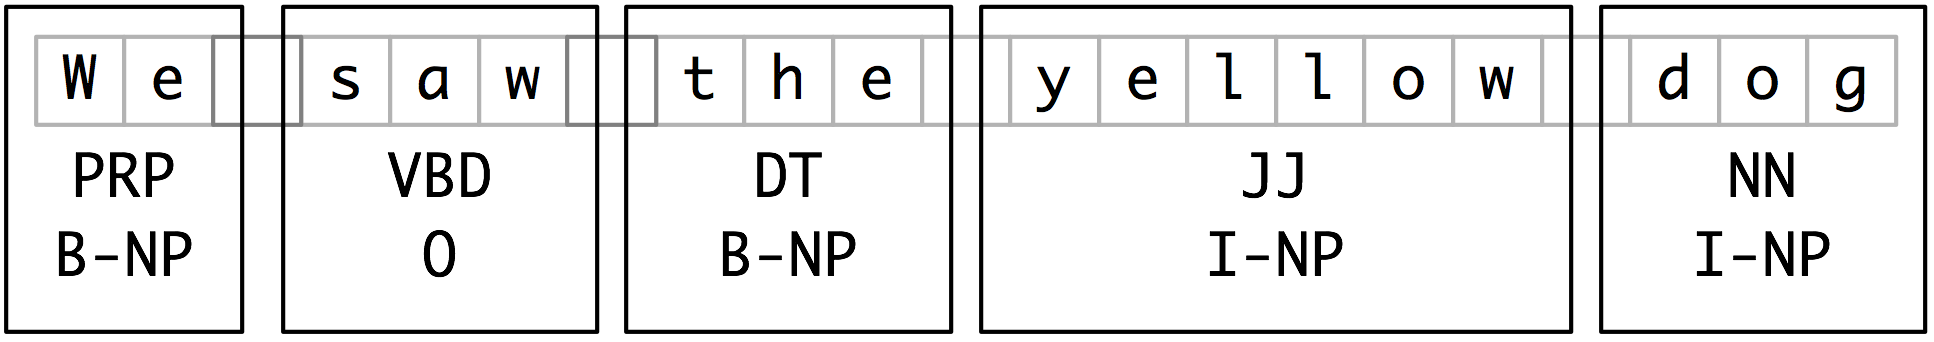

IOBタグは、ファイル内のチャンク構造を表すための標準的な方法になりました。また、この形式も使用します。上図の情報がファイルにどのように表示されるかは次のとおりです。

    We PRP B-NP
    saw VBD O
    the DT B-NP
    yellow JJ I-NP
    dog NN I-NP
    
この表現では、1行に1つのトークンがあり、それぞれに品詞タグとチャンクタグが付いています。このフォーマットにより、チャンクが重ならない限り、複数のチャンクタイプを表すことができます。先ほど見たように、チャンク構造は木を使って表すこともできます。これらには、各チャンクが直接操作できる構成要素であるという利点があります。例を下図に示します

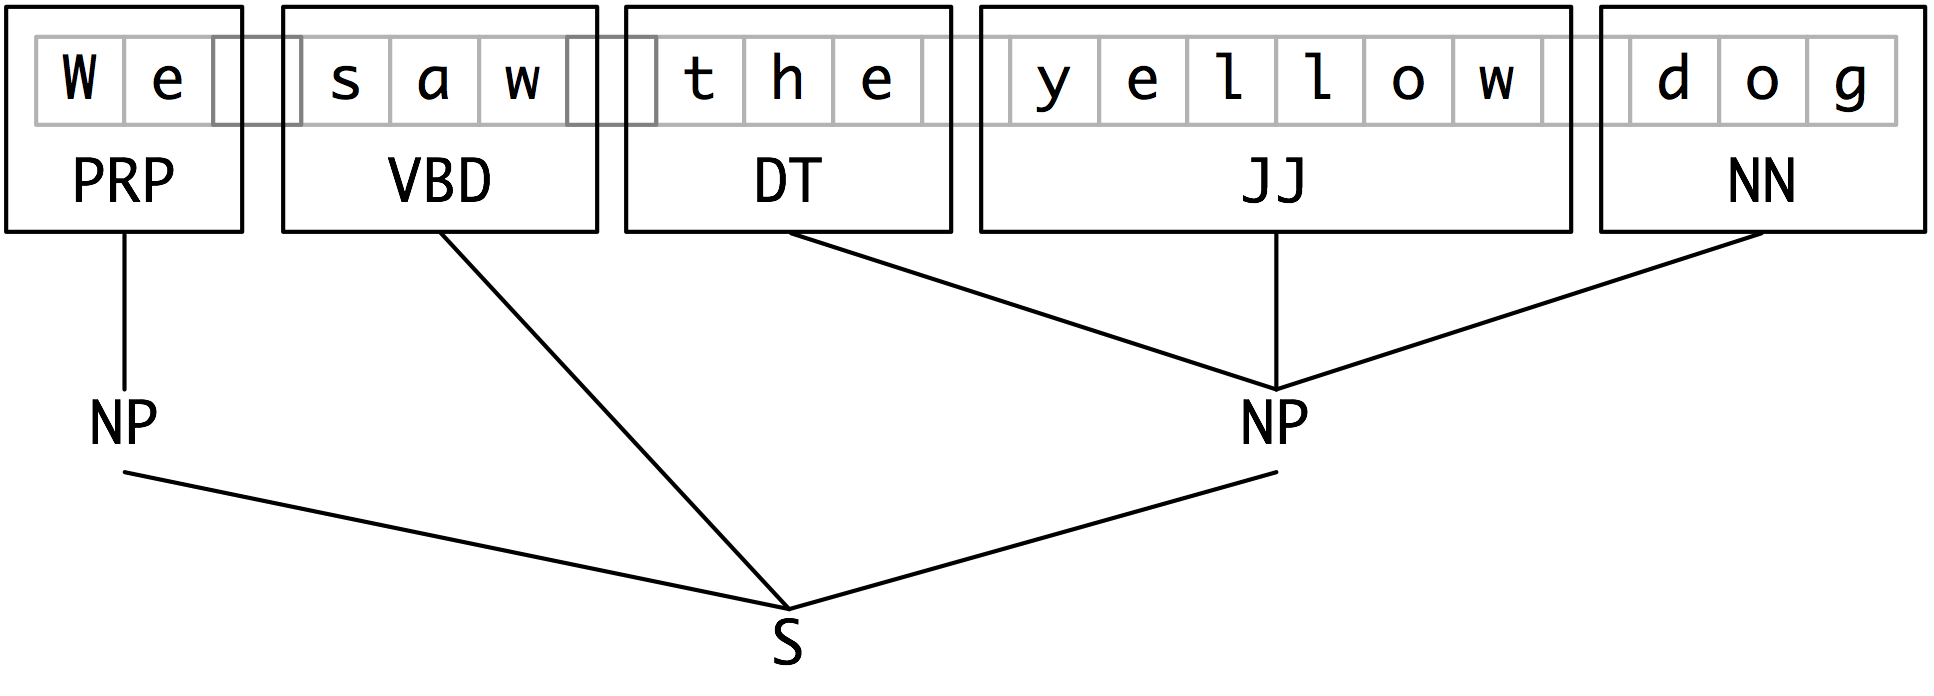![image.png](attachment:image.png)

## 9.3.  Developing and Evaluating Chunkers

(★ Assignmen Remark)  
チャンクを評価する方法
- 適切に注釈が付けられたコーパスが必要
 - IOB形式をNLTKツリーに変換する仕組みを調べてから、チャンクコーパスを使用してこれを大規模に行う方法について説明します。
 - コーパスと比較してチャンクの精度をスコア化する方法を見てから、NPチャンクを検索するためのデータ駆動型の方法をいくつか見ていきます。

### 9.3.1. IOBフォーマットとCoNLL 2000コーパスの読み方

Corpusモジュールを使用して、タグ付けされ、IOB表記を使用してチャンクされたWall Street Journalのテキストを読み込むことができます。このコーパスで提供されるチャンクカテゴリは、NP、VP、およびPPです。

    he PRP B-NP
    accepted VBD B-VP
    the DT B-NP
    position NN I-NP
    ...

変換関数chunk.conllstr2tree（）は、これらの複数行の文字列の1つからツリー表現を構築します。さらに、3つのチャンクタイプの中から任意のサブセットを選択することもできます。ここではNPチャンクだけに使用します。

In [ ]:
text = '''
he PRP B-NP
accepted VBD B-VP
the DT B-NP
position NN I-NP
of IN B-PP
vice NN B-NP
chairman NN I-NP
of IN B-PP
Carlyle NNP B-NP
Group NNP I-NP
, , O
a DT B-NP
merchant NN I-NP
banking NN I-NP
concern NN I-NP
. . O
'''
# This sell is not move on Google Colab
nltk.chunk.conllstr2tree(text, chunk_types=['NP']).draw()

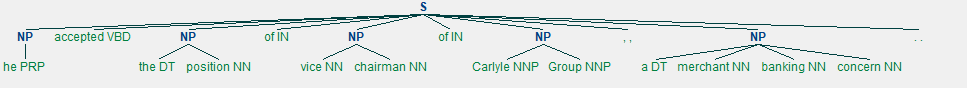

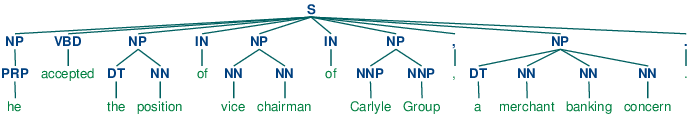

NLTK Corpusモジュールを使用して、大量のチャンクテキストにアクセスできます。CoNLL 2000コーパスには、「列車」と「テスト」の部分に分けられ、IOB形式の品詞タグとチャンクタグが付いた、270,000ワードのWall Street Journalのテキストが含まれています。nltk.corpus.conll2000を使用してデータにアクセスできます。これは、コーパスの「train」部分の100番目の文を読む例です。

In [ ]:
nltk.download('conll2000')
from nltk.corpus import conll2000
print(conll2000.chunked_sents('train.txt')[99])

[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\yagu1\AppData\Roaming\nltk_data...


(S
  (PP Over/IN)
  (NP a/DT cup/NN)
  (PP of/IN)
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  (VP told/VBD)
  (NP his/PRP$ story/NN)
  ./.)


[nltk_data]   Unzipping corpora\conll2000.zip.


CoNLL 2000コーパスには3種類のチャンクが含まれています  。NPチャンク。このようなVPチャンクはすでに配信され ています。及びPPのようなチャンクのため。今のところNPチャンクにしか興味がないので、  chunk_types引数を使ってそれらを選択することができます。

In [ ]:
print(conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99])

(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


### 9.3.2. Simple Evaluation and Baselines
チャンクコーパスにアクセスできるようになったので、チャンクを評価できます。チャンクを作成しない簡単なチャンクパーサーcpのベースラインを確立することから始めます。

In [ ]:
from nltk.corpus import conll2000
cp = nltk.RegexpParser("")
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


IOBタグ精度は、３分の１を超える単語がOでタグ付けされている、すなわちNPチャンク内ではないことを示している。しかしながら、Precesion, Recall, F-measureは全てゼロとなっています。ここに、名詞句のタグに特有の文字で始まるタグ（例：CD、DT、JJ）を探す単純な正規表現のチャンクを試してみましょう。

In [ ]:
grammar = r"NP: {<[CDJNP].*>+}"
cp = nltk.RegexpParser(grammar)
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


見てわかるように、このアプローチはまともな結果を達成します。ただし、データ主導型のアプローチを採用することで、これを改善できます。トレーニングコーパスを使用して、品詞タグごとに最も可能性の高いチャンクタグ（I、O、またはB）を見つけます。
 - unigram taggerを利用してChunkerを構築できる。

UnigramChunkerクラスの定義:

 - NLTKのChunkParserI インターフェイスで使用されるチャンクツリー表現と、埋め込みタガーで使用されるIOB表現との間の変換に使用されます。
 - このクラスは2つのメソッドを定義し[1]ます。
  - 新しいUnigramChunkerを構築するときに呼び出されるコンストラクタ
  - して新しい文をまとめるために使われるparseメソッド[3]。

In [ ]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents): #[1]
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data) #[2]

    def parse(self, sentence): #[3]
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [ ]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
unigram_chunker = UnigramChunker(train_sents)
print(unigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


このチャンクは合理的にうまく機能し、全体のf測定スコアは83％になります。ユニグラムタガーを使用して、コーパスに表示される品詞タグのそれぞれにタグを割り当てることによって、学習内容を見てみましょう。

In [ ]:
postags = sorted(set(pos for sent in train_sents
                     for (word,pos) in sent.leaves()))
print(unigram_chunker.tagger.tag(postags))

[('#', 'B-NP'), ('$', 'B-NP'), ("''", 'O'), ('(', 'O'), (')', 'O'), (',', 'O'), ('.', 'O'), (':', 'O'), ('CC', 'O'), ('CD', 'I-NP'), ('DT', 'B-NP'), ('EX', 'B-NP'), ('FW', 'I-NP'), ('IN', 'O'), ('JJ', 'I-NP'), ('JJR', 'B-NP'), ('JJS', 'I-NP'), ('MD', 'O'), ('NN', 'I-NP'), ('NNP', 'I-NP'), ('NNPS', 'I-NP'), ('NNS', 'I-NP'), ('PDT', 'B-NP'), ('POS', 'B-NP'), ('PRP', 'B-NP'), ('PRP$', 'B-NP'), ('RB', 'O'), ('RBR', 'O'), ('RBS', 'B-NP'), ('RP', 'O'), ('SYM', 'O'), ('TO', 'O'), ('UH', 'O'), ('VB', 'O'), ('VBD', 'O'), ('VBG', 'O'), ('VBN', 'O'), ('VBP', 'O'), ('VBZ', 'O'), ('WDT', 'B-NP'), ('WP', 'B-NP'), ('WP$', 'B-NP'), ('WRB', 'O'), ('``', 'O')]


通貨マーカーとして使用される#と$＄$を除いて、ほとんどの句読点がNPチャンクの外側にあることが発見されました。また、決定詞（DT）と所有（PRP ＄とWP ＄）がNPチャンクの先頭にあるのに対し、名詞型（NN、NNP、NNPS、NNS）は主にNPチャンクの内部にあることがわかりました。
ユニグラムチャンクを構築したので、バイグラムチャンクを構築するのは非常に簡単です.

In [ ]:
class BigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents): #[1]
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data) #[2]

    def parse(self, sentence): #[3]
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [ ]:
bigram_chunker = BigramChunker(train_sents)
print(bigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     82.3%%
    Recall:        86.8%%
    F-Measure:     84.5%%


### 9.3.3   Training Classifier-Based Chunkers
正規表現ベースのチャンクとn-gramチャンクの両方は、完全に品詞タグに基づいて作成するチャンクを決定します。ただし、場合によっては品詞タグだけで文をまとめる方法を決定できないことがあります。たとえば、次の2つの文を考えてください。
	
    a.		Joey/NN sold/VBD the/DT farmer/NN rice/NN ./.
    b.		Nick/NN broke/VBD my/DT computer/NN monitor/NN ./.

これら2つの文には同じ品詞タグが付いていますが、チャンクは異なっています。

最初の文で は、farmerとriceは別々のチャンクですが、2番目の文で対応する computer monitor は単一のチャンクです。明らかに、チャンキングパフォーマンスを最大化したいのであれば、それらの品詞タグだけでなく単語の内容に関する情報を利用する必要があります。

ClassifireベースのNPチャンクの基本コードを以下に示します。

- 最初のクラス[1]は1.5からのConsecutivePosTaggerクラスとほとんど同じです 。
 - 唯一の2つの違いは、それが異なる特徴抽出器を呼び出すことと、NaiveBayesClassifierではなくMaxentClassifierを使用することです。
- 2番目のクラス は基本的にそれをチャンクに変えるtaggerクラスの周りのラッパーです。
 - トレーニング中に、この2番目のクラスはトレーニングコーパス内のチャンクツリーをタグシーケンスにマッピングします。 parse(）メソッドは、バックチャンクツリーにタガーによって提供されるタグ配列を変換します。[2][3][4]

注意: 原文の例はMegaMと呼ばれるモジュールを利用しますが、どうやらNLTKに直接含まれないファイルのようですので、動作しません。IISと呼ばれる別なアルゴリズムを利用しますが、精度が出ません。

In [ ]:
class ConsecutiveNPChunkTagger(nltk.TaggerI): #[1]

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) #[2]
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train( #[3]
            train_set, algorithm='IIS', trace=0)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): #[4]
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

現在のトークンの品詞タグを提供する単純な機能抽出プログラムを定義することから始めます。この特徴抽出器を使うと、その性能に反映されるように、私たちのクラシファイアベースのチャンクはユニグラムチャンクに非常に似ています。  
(注: 動作が非常に遅いです。)

In [ ]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}
chunker = ConsecutiveNPChunker(train_sents)
print(chunker.evaluate(test_sents))

前の品詞タグの機能を追加することもできます。この機能を追加すると、分類子は隣接するタグ間の相互作用をモデル化することができ、その結果、バイグラムチャンクに密接に関連したチャンクが得られます。  
(注: 動作が非常に遅いです。)

In [ ]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    return {"pos": pos, "prevpos": prevpos}
chunker = ConsecutiveNPChunker(train_sents)
print(chunker.evaluate(test_sents))

次に、単語の内容がチャンクに役立つはずであるという仮説を立てたので、現在の単語に機能を追加してみます。この機能により、チャンクのパフォーマンスが実際に約1.5パーセントポイント向上します（これはエラー率の約10％の低下に相当します）。  
(注: 動作が非常に遅いです。)

In [ ]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    return {"pos": pos, "word": word, "prevpos": prevpos}
chunker = ConsecutiveNPChunker(train_sents)
print(chunker.evaluate(test_sents))

最後に、先読み機能[1]、ペア機能[2]、複雑なコンテキスト機能など、さまざまな追加機能を使用して機能抽出機能を拡張してみることができます[3]。tags-since-dtと呼ばれるこの最後の機能は、最新の判定器以降、またはインデックスiの前に判定器がない場合は文の先頭以降に検出されたすべての品詞タグのセットを記述する文字列を作成します。  
(注: 動作が非常に遅いです。)

In [ ]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    if i == len(sentence)-1:
        nextword, nextpos = "<END>", "<END>"
    else:
        nextword, nextpos = sentence[i+1]
    return {"pos": pos,
            "word": word,
            "prevpos": prevpos,
            "nextpos": nextpos, #[1]
            "prevpos+pos": "%s+%s" % (prevpos, pos),  #[2]
            "pos+nextpos": "%s+%s" % (pos, nextpos),
            "tags-since-dt": tags_since_dt(sentence, i)}  #[3]

In [ ]:
def tags_since_dt(sentence, i):
    tags = set()
    for word, pos in sentence[:i]:
        if pos == 'DT':
            tags = set()
        else:
            tags.add(pos)
    return '+'.join(sorted(tags))

In [ ]:
chunker = ConsecutiveNPChunker(train_sents)
print(chunker.evaluate(test_sents))

## 9.4.   Recursion in Linguistic Structure
### 9.4.1. Building Nested Structure with Cascaded Chunkers

これまでのところ、私たちのチャンク構造は比較的平坦でした。木は、オプションでNPなどのチャンクノードの下にグループ化されたタグ付きトークンで構成されています 。しかし、再帰的な規則を含む多段チャンク文法を作成することによって、任意の深さのチャンク構造を構築することは可能です。

以下の例には名詞句、前置詞句、動詞句、文のパターンがあります。これは4段階のチャンク文法で、深さが最大4の構造を作成するために使用できます。

In [ ]:
grammar = r"""
  NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
  VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
  CLAUSE: {<NP><VP>}           # Chunk NP, VP
  """
cp = nltk.RegexpParser(grammar)
sentence = [("Mary", "NN"), ("saw", "VBD"), ("the", "DT"), ("cat", "NN"),
    ("sit", "VB"), ("on", "IN"), ("the", "DT"), ("mat", "NN")]

In [ ]:
print(cp.parse(sentence))

残念ながら、この結果はsawが率いるVPを逃しています。他にも欠点があります。このチャンクをより深いネスティングを持つ文に適用するとどうなるか見てみましょう。で始まるVPチャンクを識別できないことに注意してください。

In [ ]:
sentence = [("John", "NNP"), ("thinks", "VBZ"), ("Mary", "NN"),
    ("saw", "VBD"), ("the", "DT"), ("cat", "NN"), ("sit", "VB"),
    ("on", "IN"), ("the", "DT"), ("mat", "NN")]
print(cp.parse(sentence))

これらの問題に対する解決策は、チャンクにそのパターンをループさせることです。それらすべてを試した後、それはプロセスを繰り返します。

In [ ]:
cp = nltk.RegexpParser(grammar, loop=2)
print(cp.parse(sentence))

### 9.4.2 Tree
Treeとは、根（Sentence）からループのない接続によって作られるグラフである。

Treeの例

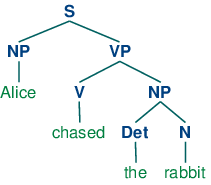

ツリー内のノードの関係について話すために、「家族」の比喩を使用します。たとえば、SはVPの 親です。逆にVPはSの子 です。また、NPとVPはどちらもSの子であるため、兄弟でもあります。便宜上、木を指定するためのテキストフォーマットもあります。

    (S
       (NP Alice) 
       (VP
          (V chased)
          (NP
             (Det the)
             (N rabbit))))

NLTKでは、ノードラベルと子のリストを指定してツリーを作成します。

In [ ]:
tree1 = nltk.Tree('NP', ['Alice'])
print(tree1)

In [ ]:
tree2 = nltk.Tree('NP', ['the', 'rabbit'])
print(tree2)

In [ ]:
tree3 = nltk.Tree('VP', ['chased', tree2])
tree4 = nltk.Tree('S', [tree1, tree3])
print(tree4)

Treeオブジェクトで使用できる幾つかのメソッド

In [ ]:
print(tree4[1])

In [ ]:
tree4[1].label()

In [ ]:
tree4.leaves()

In [ ]:
tree4[1][1][1]

In [ ]:
tree3.draw()

![image.png](attachment:image.png)

### 9.4.3. Tree Traversal
木を走査するためには再帰関数を使うのが標準的です。
下記のtraverse()関数は再帰を用いて木構造を走査します。

注意: nltk.orgのコード(https://www.nltk.org/book/ch07.html#code-traverse) は、Python3系ではエラーが出ます。下記のように、nltk.Tree.fromstring()としてください

In [ ]:
def traverse(t):
    try:
        t.label()
    except AttributeError:
        print(t, end=" ")
    else:
        # Now we know that t.node is defined
        print('(', t.label(), end=" ")
        for child in t:
            traverse(child)
        print(')', end=" ")

In [ ]:
t = nltk.Tree.fromstring('(S (NP Alice) (VP chased (NP the rabbit)))')
traverse(t)

## 9.5. Named Entity Recognition

この章の始めに、名前付きエンティティ（NE）を簡単に紹介しました。

名前付きエンティティは、組織、個人、日付など、特定の種類の個人を指す明確な名詞句です。

以下のリストは、NEのより一般的に使用されるタイプのいくつかをリストします。
![image.png](attachment:image.png)

名前付きエンティティの識別方法について:
 - 1つの選択肢は、適切な名前のリストで各単語を検索することです。
  - たとえば、場所の場合は、地名辞典、またはAlexandria GazetteerやGetty Gazetteerなどの地理的な辞書を使用できます。
  - しかし、これを行うと、以下に示すように盲目的に問題が発生します。
![image.png](attachment:image.png)
  - ニュース記事の単純検索による位置検出：地名辞典のすべての単語を検索するのは誤りがちです。大文字と小文字の区別は役立ちますが、これらが常に存在するとは限りません。
  
名前付きエンティティの認識は、名詞句のチャンキングに対して見た分類子ベースのアプローチの種類に適したタスクです。

特に、チャンクが適切なタイプでラベル付けされているIOB形式を使用して、文中の各単語にラベルを付けるタガーを作成できます。これは、CONLL 2002（conll 2002 ）Dutch トレーニングデータの一部です。

    Eddy N B-PER
    Bonte N I-PER
    is V O
    woordvoerder N O
    van Prep O
    diezelfde Pron O
    Hogeschool N B-ORG
    . Punc O

この表現では、1行に1つのトークンがあり、それぞれに品詞タグと名前付きエンティティタグが付いています。このトレーニングコーパスに基づいて、新しい文にラベルを付けるために使用できるタガーを構築できます。タグシーケンスをチャンクツリーに変換するには、nltk.chunk.conlltags2tree（）関数を使用します。

NLTKは、関数nltk.ne_chunk（）でアクセスされる名前付きエンティティを認識するようにすでに訓練された分類子を提供します。
 - パラメータbinary = True を設定した場合[1]、名前付きエンティティはNEとしてタグ付けされるだけです。
 - それ以外の場合、分類子はPERSON、ORGANIZATION、およびGPEなどのカテゴリラベルを追加します。

In [ ]:
nltk.download('treebank')
nltk.download('maxent_ne_chunker')
nltk.download('words')
sent = nltk.corpus.treebank.tagged_sents()[22]
print(nltk.ne_chunk(sent, binary=True)) #[1]

In [ ]:
print(nltk.ne_chunk(sent)) 

名前付きエンティティがテキストで識別されたら、次にそれらの間に存在する関係を抽出します。
 - 前述のように、私たちは通常、指定されたタイプの名前付きエンティティ間の関係を探します。
 - このタスクにアプローチする1つの方法は、最初にフォームのすべてのトリプル（X、α、Y）を探すことです。
 - ここで、XとYは必要なタイプのエンティティと命名され、αはXとYの間に介在する単語のストリングです。
 - そして、正規表現を使って、探している関係を表すαのインスタンスだけを取り出すことができます。

In [ ]:
nltk.download('ieer')
IN = re.compile(r'.*\bin\b(?!\b.+ing)')
for doc in nltk.corpus.ieer.parsed_docs('NYT_19980315'):
    for rel in nltk.sem.extract_rels('ORG', 'LOC', doc,
                                     corpus='ieer', pattern = IN):
        print(nltk.sem.rtuple(rel))

In [ ]:
nltk.download('conll2002')
from nltk.corpus import conll2002
vnv = """
(
is/V|    # 3rd sing present and
was/V|   # past forms of the verb zijn ('be')
werd/V|  # and also present
wordt/V  # past of worden ('become)
)
.*       # followed by anything
van/Prep # followed by van ('of')
"""
VAN = re.compile(vnv, re.VERBOSE)
for doc in conll2002.chunked_sents('ned.train'):
    for r in nltk.sem.extract_rels('PER', 'ORG', doc,
                                   corpus='conll2002', pattern=VAN):
        print(nltk.sem.clause(r, relsym="VAN")) #[1]